# Import Dependencies

In [1]:
# import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import preprocessing
import time
from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Dataset

In [3]:
# read covid-19 and mobility dataset
data_covid = pd.read_csv("/content/drive/MyDrive/COMPFEST.ID/Jakarta & Dunia/covid_19_data.csv/covid_19_data.csv")
data_mobility = pd.read_csv("/content/drive/MyDrive/COMPFEST.ID/Mobility/Global_Mobility_Report.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Understanding Data

## Data COVID-19

We retrieved COVID-19 data from Novel Corona Virus 2019 Dataset that is available on Kaggle (https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset).


In [4]:
# look at top 5 of covid data
data_covid.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [5]:
# look at row and column number of covid dataset
data_covid.shape

(306429, 8)

In [6]:
# rename column that uses "/" and " "
data_covid.rename(columns = {'Province/State':'Province', 'Country/Region':'Country', 'Last Update':'LastUpdate' }, inplace = True)

In [7]:
# look again at top 5 of covid dataset
data_covid.head()

,SNo,ObservationDate,Province,Country,LastUpdate,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [8]:
# look at bottom 5 of covid dataset
data_covid.tail()

,SNo,ObservationDate,Province,Country,LastUpdate,Confirmed,Deaths,Recovered
306424,306425,05/29/2021,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,306426,05/29/2021,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,306427,05/29/2021,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,306428,05/29/2021,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0
306428,306429,05/29/2021,Zuid-Holland,Netherlands,2021-05-30 04:20:55,391559.0,4252.0,0.0


In [9]:
# look at null values and datatypes of covid dataset
data_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306429 entries, 0 to 306428
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   SNo              306429 non-null  int64  
 1   ObservationDate  306429 non-null  object 
 2   Province         228329 non-null  object 
 3   Country          306429 non-null  object 
 4   LastUpdate       306429 non-null  object 
 5   Confirmed        306429 non-null  float64
 6   Deaths           306429 non-null  float64
 7   Recovered        306429 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 18.7+ MB


In [10]:
# rename ObservationDate to date since we're going to merge 2 dataset, and merge it based on date
data_covid.rename(columns = {'ObservationDate':'date'}, inplace = True)

In [11]:
# convert ObservationDate and LastUpdate to datetime datatypes
data_covid["date"]=pd.to_datetime(data_covid["date"])
data_covid["LastUpdate"]=pd.to_datetime(data_covid["LastUpdate"])

In [12]:
# checking missing value
print("Jumlah missing value tiap kolom:", data_covid.isna().sum())

Jumlah missing value tiap kolom: SNo               0
date              0
Province      78100
Country           0
LastUpdate        0
Confirmed         0
Deaths            0
Recovered         0
dtype: int64


In [13]:
# filter Country that contains Indonesia
jakarta = (data_covid["Province"] == "DKI Jakarta")

# made a new dataset that only contains Indonesia as its Country
data_covid_jakarta = data_covid.loc[jakarta]

# look at top 5 of our new dataset that focusing in Indonesia Covid-19 case
data_covid_jakarta.head()

,SNo,date,Province,Country,LastUpdate,Confirmed,Deaths,Recovered


In [14]:
"""
drop Province, since we're going to focus in Indonesia,
and all Indonesia's province has null values, so better delete it.

drop SNo since it has no significance in our analysis.
"""
data_covid.drop("Province",1,inplace=True)
data_covid.drop("SNo",1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [15]:
# look again at our top 5 covid dataset
data_covid.head()

,date,Country,LastUpdate,Confirmed,Deaths,Recovered
0,2020-01-22,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2020-01-22,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,2020-01-22,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,2020-01-22,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,2020-01-22,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


In [16]:
# look again at bottom 5 of our covid dataset
data_covid.tail()

,date,Country,LastUpdate,Confirmed,Deaths,Recovered
306424,2021-05-29,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,2021-05-29,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,2021-05-29,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,2021-05-29,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0
306428,2021-05-29,Netherlands,2021-05-30 04:20:55,391559.0,4252.0,0.0


### Made a new dataset focusing in Indonesia

In [17]:
# filter Country that contains Indonesia
indonesia = (data_covid["Country"] == "Indonesia")

# made a new dataset that only contains Indonesia as its Country
data_covid_indonesia = data_covid.loc[indonesia]

# look at top 5 of our new dataset that focusing in Indonesia Covid-19 case
data_covid_indonesia.head()

,date,Country,LastUpdate,Confirmed,Deaths,Recovered
3114,2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0
3258,2020-03-03,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0
3421,2020-03-04,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0
3590,2020-03-05,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0
3760,2020-03-06,Indonesia,2020-03-06 12:33:03,4.0,0.0,0.0


In [18]:
# look at bottom 5 of our new dataset that focusing in Indonesia Covid-19 case
data_covid_indonesia.tail()

,date,Country,LastUpdate,Confirmed,Deaths,Recovered
302674,2021-05-25,Indonesia,2021-05-26 04:20:35,1786187.0,49627.0,1642074.0
303439,2021-05-26,Indonesia,2021-05-27 04:20:59,1791221.0,49771.0,1645263.0
304204,2021-05-27,Indonesia,2021-05-28 04:20:36,1797499.0,49907.0,1649187.0
304969,2021-05-28,Indonesia,2021-05-29 04:20:41,1803361.0,50100.0,1654557.0
305734,2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0


In [19]:
# look at row and column number of Indonesia Covid-19 dataset
data_covid_indonesia.shape

(454, 6)

## Data Mobility

We retrieved mobility data from the Google Community Mobility Report (CMR), where Google collected anonymized users' location history data. 


---

Later on, we will use daily aggregated mobility data in Indonesia from 2 March 2020 to 29 May 2021. 

The descriptions of the places are as follows:
1. Retail and Recreational: mobility towards places such as restaurants, cafes, shopping
centers, museums, libraries, and picture theatres;
2. Grocery and Pharmacy:  mobility trends for places such as grocery shops, food warehouses, markets, local hats, farmer’s markets, specialty food shops, different drug or
medicine stores, and pharmacies;
3. Parks: places of attraction including local parks, national parks, public beaches,
marinas, dog parks, plazas, and public gardens;
4. Transit stations: a process by which a person moves from one place to places like
public transport hubs such as subway, bus, and train stations;
5. Workplaces: the process of going to places of work from a home;
6. Residential mobility: mobility in the direction of places of residence where a person lived.



In [20]:
# look at top 5 of mobility dataset
data_mobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [21]:
# look at row and column number of mobility dataset
data_mobility.shape

(10477102, 15)

In [22]:
# checking missing value
print("Jumlah missing value tiap kolom:\n",data_mobility.isna().sum())

Jumlah missing value tiap kolom:
 country_region_code                                       6524
country_region                                               0
sub_region_1                                            173236
sub_region_2                                           1703539
metro_area                                            10420817
iso_3166_2_code                                        8649577
census_fips_code                                       8245572
place_id                                                 19281
date                                                         0
retail_and_recreation_percent_change_from_baseline     3987247
grocery_and_pharmacy_percent_change_from_baseline      4288258
parks_percent_change_from_baseline                     5536338
transit_stations_percent_change_from_baseline          5281581
workplaces_percent_change_from_baseline                 372843
residential_percent_change_from_baseline               4047574
dtype: int64


In [23]:
"""
drop country_region_code since it has the same function with country_region,
drop sub_region_1 since we're just going to focus on country's
and so do on sub_region_2.
drop metro_area since it has almost 100% of null values.
drop iso_3166_2_code, census_fips_code, place_id since it hasn't give any significance to our analysis.
"""
data_mobility = data_mobility.drop('country_region_code', axis=1)
data_mobility = data_mobility.drop('sub_region_2', axis=1)
data_mobility = data_mobility.drop('metro_area', axis=1)
data_mobility = data_mobility.drop('iso_3166_2_code', axis=1)
data_mobility = data_mobility.drop('census_fips_code', axis=1)
data_mobility = data_mobility.drop('place_id', axis=1)

In [24]:
"""
fill columns that hass null values with their median values
"""
data_mobility["retail_and_recreation_percent_change_from_baseline"] = data_mobility["retail_and_recreation_percent_change_from_baseline"].fillna(data_mobility["retail_and_recreation_percent_change_from_baseline"].median()) # Median
data_mobility["grocery_and_pharmacy_percent_change_from_baseline"] = data_mobility["grocery_and_pharmacy_percent_change_from_baseline"].fillna(data_mobility["grocery_and_pharmacy_percent_change_from_baseline"].median())
data_mobility["parks_percent_change_from_baseline"] = data_mobility["parks_percent_change_from_baseline"].fillna(data_mobility["parks_percent_change_from_baseline"].median())
data_mobility["transit_stations_percent_change_from_baseline"] = data_mobility["transit_stations_percent_change_from_baseline"].fillna(data_mobility["transit_stations_percent_change_from_baseline"].median())
data_mobility["workplaces_percent_change_from_baseline"] = data_mobility["workplaces_percent_change_from_baseline"].fillna(data_mobility["workplaces_percent_change_from_baseline"].median())
data_mobility["residential_percent_change_from_baseline"] = data_mobility["residential_percent_change_from_baseline"].fillna(data_mobility["residential_percent_change_from_baseline"].median())

In [25]:
# checking missing value
print("Jumlah missing value tiap kolom:\n",data_mobility.isna().sum())

Jumlah missing value tiap kolom:
 country_region                                             0
sub_region_1                                          173236
date                                                       0
retail_and_recreation_percent_change_from_baseline         0
grocery_and_pharmacy_percent_change_from_baseline          0
parks_percent_change_from_baseline                         0
transit_stations_percent_change_from_baseline              0
workplaces_percent_change_from_baseline                    0
residential_percent_change_from_baseline                   0
dtype: int64


In [26]:
# checking mobility dataset datatypes
data_mobility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10477102 entries, 0 to 10477101
Data columns (total 9 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   country_region                                      object 
 1   sub_region_1                                        object 
 2   date                                                object 
 3   retail_and_recreation_percent_change_from_baseline  float64
 4   grocery_and_pharmacy_percent_change_from_baseline   float64
 5   parks_percent_change_from_baseline                  float64
 6   transit_stations_percent_change_from_baseline       float64
 7   workplaces_percent_change_from_baseline             float64
 8   residential_percent_change_from_baseline            float64
dtypes: float64(6), object(3)
memory usage: 719.4+ MB


In [27]:
# convert date on mobility datset into datetime datatypes
data_mobility['date'] =  pd.to_datetime(data_mobility['date'])

In [28]:
# check again mobility dataset datatypes
data_mobility.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10477102 entries, 0 to 10477101
Data columns (total 9 columns):
 #   Column                                              Dtype         
---  ------                                              -----         
 0   country_region                                      object        
 1   sub_region_1                                        object        
 2   date                                                datetime64[ns]
 3   retail_and_recreation_percent_change_from_baseline  float64       
 4   grocery_and_pharmacy_percent_change_from_baseline   float64       
 5   parks_percent_change_from_baseline                  float64       
 6   transit_stations_percent_change_from_baseline       float64       
 7   workplaces_percent_change_from_baseline             float64       
 8   residential_percent_change_from_baseline            float64       
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 719.4+ MB


In [29]:
# rename country_region since we're going to merge 2 dataset, and merge it based on country's name
data_mobility.rename(columns = {'country_region':'Country'}, inplace = True)

In [30]:
# set date to become mobility dataset index
data_mobility = data_mobility.set_index("date")

In [31]:
# look at top 5 of mobility dataset
data_mobility.head()

,Country,sub_region_1,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,
2020-02-15,United Arab Emirates,NaN,0.0,4.0,5.0,0.0,2.0,1.0
2020-02-16,United Arab Emirates,NaN,1.0,4.0,4.0,1.0,2.0,1.0
2020-02-17,United Arab Emirates,NaN,-1.0,1.0,5.0,1.0,2.0,1.0
2020-02-18,United Arab Emirates,NaN,-2.0,1.0,5.0,0.0,2.0,1.0
2020-02-19,United Arab Emirates,NaN,-2.0,0.0,4.0,-1.0,2.0,1.0


In [32]:
# look at bottom 5 of mobility dataset
data_mobility.tail()

,Country,sub_region_1,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,
2022-06-23,Zimbabwe,Midlands Province,-8.0,7.0,-4.0,-18.0,137.0,6.0
2022-06-24,Zimbabwe,Midlands Province,-8.0,7.0,-4.0,-18.0,139.0,6.0
2022-06-27,Zimbabwe,Midlands Province,-8.0,7.0,-4.0,-18.0,124.0,6.0
2022-06-29,Zimbabwe,Midlands Province,-8.0,7.0,-4.0,-18.0,139.0,6.0
2022-06-30,Zimbabwe,Midlands Province,-8.0,7.0,-4.0,-18.0,135.0,6.0


Since, we're going to merge two dataset(data_covid_indonesia & data_mobility_indonesia),then both of it, should have same date so all the data could correlate to each other.
So, when each dataset starts and end?
*   data_covid_indonesia
start: 2020-03-02
end: 2021-05-29
*   data_mobility_indonesia
start: 2020-02-15
end: 2021-05-29 
NEXT, to merge it all, we needed date that is 'inner join'
---
Because data_mobility_indonesia started early rather than data_covid_indonesia, data_mobility_indonesia will be changed into just like data_covid_indonesia date started.
So, data_mobility_indonesia then again will be set on:
*   start: 2020-03-02
*   end: 2021-05-29






In [33]:
data_mobility = data_mobility['2020-03-02' :'2021-05-29']

In [34]:
# look at row and column number of mobility dataset
data_mobility.shape

(5394828, 8)

### Made a new dataset focusing in Indonesia

In [35]:
# define mobility that Indonesia as it's only country
indonesia_mobility = (data_mobility["Country"] == "Indonesia")

# new dataset of mobility in indonesia
data_mobility_indonesia = data_mobility.loc[indonesia_mobility]

# look at top 5 of indonesia mobility dataset
data_mobility_indonesia.head()

,Country,sub_region_1,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,
2020-03-02,Indonesia,NaN,5.0,12.0,0.0,3.0,5.0,0.0
2020-03-03,Indonesia,NaN,3.0,10.0,-2.0,2.0,5.0,0.0
2020-03-04,Indonesia,NaN,0.0,4.0,-5.0,-1.0,4.0,1.0
2020-03-05,Indonesia,NaN,4.0,8.0,-1.0,3.0,4.0,0.0
2020-03-06,Indonesia,NaN,2.0,4.0,-3.0,3.0,6.0,1.0


In [36]:
# look at bottom 5 of indonesia mobility dataset
data_mobility_indonesia.tail()

,Country,sub_region_1,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,
2021-05-25,Indonesia,West Sumatra,16.0,51.0,26.0,17.0,-22.0,1.0
2021-05-26,Indonesia,West Sumatra,26.0,54.0,64.0,16.0,-56.0,10.0
2021-05-27,Indonesia,West Sumatra,19.0,48.0,18.0,11.0,-21.0,4.0
2021-05-28,Indonesia,West Sumatra,11.0,40.0,2.0,-1.0,-16.0,6.0
2021-05-29,Indonesia,West Sumatra,12.0,39.0,4.0,-1.0,-18.0,5.0


In [37]:
# look at row and column number of indonesia mobility dataset
data_mobility_indonesia.shape

(15890, 8)

## Dataset Indonesia (COVID & Mobility)

In [38]:
# define new dataset that merging indonesia's covid and mobility data
dataset = pd.merge(data_covid_indonesia, data_mobility_indonesia.reset_index(), on=["date","Country"], how="inner").set_index("date")

In [39]:
# look at top 5 of this merged dataset
dataset.head()

,Country,LastUpdate,Confirmed,Deaths,Recovered,sub_region_1,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,NaN,5.0,12.0,0.0,3.0,5.0,0.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Aceh,6.0,5.0,5.0,5.0,10.0,0.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Bali,4.0,11.0,-3.0,-12.0,1.0,-1.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Bangka Belitung Islands,2.0,8.0,0.0,-6.0,6.0,0.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Banten,9.0,16.0,12.0,1.0,6.0,-1.0


In [40]:
# look at bottom 5 of this newly merged dataset
dataset.tail()

,Country,LastUpdate,Confirmed,Deaths,Recovered,sub_region_1,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Kalimantan,-17.0,4.0,-18.0,-25.0,-16.0,2.0
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Nusa Tenggara,8.0,36.0,17.0,-12.0,-18.0,-3.0
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Papua,-4.0,36.0,-28.0,-16.0,-16.0,-7.0
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Sulawesi,8.0,47.0,5.0,24.0,-7.0,0.0
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Sumatra,12.0,39.0,4.0,-1.0,-18.0,5.0


In [41]:
# look at row and column number of this newly merged dataset
dataset.shape

(15890, 12)

In [42]:
# check duplicate index
dataset[dataset.index.duplicated()]

,Country,LastUpdate,Confirmed,Deaths,Recovered,sub_region_1,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,,
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Aceh,6.0,5.0,5.0,5.0,10.0,0.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Bali,4.0,11.0,-3.0,-12.0,1.0,-1.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Bangka Belitung Islands,2.0,8.0,0.0,-6.0,6.0,0.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Banten,9.0,16.0,12.0,1.0,6.0,-1.0
2020-03-02,Indonesia,2020-03-02 18:03:04,2.0,0.0,0.0,Bengkulu,0.0,4.0,-2.0,-1.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Kalimantan,-17.0,4.0,-18.0,-25.0,-16.0,2.0
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Nusa Tenggara,8.0,36.0,17.0,-12.0,-18.0,-3.0
2021-05-29,Indonesia,2021-05-30 04:20:55,1809926.0,50262.0,1659974.0,West Papua,-4.0,36.0,-28.0,-16.0,-16.0,-7.0


In [43]:
# groupby index (date) and sum variables that needed to be sum
dataset = dataset.groupby(dataset.index).agg({'Country': 'first',
                                              'LastUpdate': 'last',
                                              'Confirmed':sum, 
                                              'Deaths':sum,
                                              'Recovered':sum,
                                              'retail_and_recreation_percent_change_from_baseline':sum,
                                              'grocery_and_pharmacy_percent_change_from_baseline':sum,
                                              'parks_percent_change_from_baseline':sum,
                                              'transit_stations_percent_change_from_baseline':sum,
                                              'workplaces_percent_change_from_baseline':sum,
                                              'residential_percent_change_from_baseline':sum})

In [44]:
dataset

,Country,LastUpdate,Confirmed,Deaths,Recovered,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,,,,,,
2020-03-02,Indonesia,2020-03-02 18:03:04,70.0,0.0,0.0,67.0,196.0,-44.0,-8.0,159.0,12.0
2020-03-03,Indonesia,2020-03-02 18:03:04,70.0,0.0,0.0,65.0,210.0,-66.0,-19.0,176.0,11.0
2020-03-04,Indonesia,2020-03-02 18:03:04,70.0,0.0,0.0,9.0,111.0,-115.0,-62.0,159.0,42.0
2020-03-05,Indonesia,2020-03-02 18:03:04,70.0,0.0,0.0,64.0,151.0,-59.0,-27.0,167.0,23.0
2020-03-06,Indonesia,2020-03-06 12:33:03,140.0,0.0,0.0,62.0,126.0,-44.0,10.0,187.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-25,Indonesia,2021-05-26 04:20:35,62516545.0,1736945.0,57472590.0,-21.0,895.0,200.0,-247.0,-810.0,30.0
2021-05-26,Indonesia,2021-05-27 04:20:59,62692735.0,1741985.0,57584205.0,-3.0,788.0,881.0,-173.0,-1984.0,283.0
2021-05-27,Indonesia,2021-05-28 04:20:36,62912465.0,1746745.0,57721545.0,-2.0,868.0,83.0,-406.0,-730.0,49.0


In [45]:
dataset.shape

(454, 11)

# Exploratory Data Analysis

## Types of Cases

There are 3 types of cases in COVID-19:

1.   Confirmed Cases.
If one tested positive, then it is considered as a Confirmed Cases.
2.   Probable Cases.
A probable COVID-19 case could mean one of two things:
*   It is likely that you had a COVID-19 infection
*   It is likely that you have a current COVID-19 infection but it hasn't been confirmed through test(s).
3.   Active Cases.
People that is currently infected. It is case that minus people who have been recovered and deaths.
4.   Closed Cases.
If one had recovered from COVID-19 or if one had died.


### Active Cases

In [46]:
# active cases
dataset["active_cases"] = dataset["Confirmed"] - dataset["Recovered"] - dataset["Deaths"]

An increasing in the number of Active Cases could mean two things:
*   Increasing on Recovered Cases
*   Decreasing on Deaths



### Closed Cases

In [47]:
# closed cases
dataset["closed_cases"] = dataset["Recovered"] + dataset["Deaths"]

An increasing in the number of Closed Cases could mean either:
*   Increasing on Recovered Cases; 
or
*   Increasing on Deaths

## Fatality Ratio

Fatality Ratio is the ratio of people who's gone because of COVID-19.

Fatality Ratio is when you divide number of deaths (Deaths) and number of confirmed cases (Confirmed).





In [48]:
# fatality ratio
dataset["fatality_ratio"] = (dataset["Deaths"] / dataset["Confirmed"])

Fatality Ratio is affected by preparedness/access and the ability of healthcare workers to carry out examinations.

## Recovery Ratio

Recovery Ratio is important to determine a country's development towards controlling coronavirus.

In [49]:
# recovery ratio
dataset["recovery_ratio"] = (dataset["Recovered"] / dataset["Confirmed"])

Recovery Ratio is the ratio of people who had recovered from COVID-19.

## Comparative of Each Cases

In [50]:
# made a new dataset from existing dataset focusing on each column
confirmed = dataset['Confirmed'].reset_index()
deaths = dataset["Deaths"].reset_index()
recovered = dataset["Recovered"].reset_index()
active = dataset["active_cases"].reset_index()
closed = dataset["closed_cases"].reset_index()
fatality = dataset["fatality_ratio"].reset_index()
recovery = dataset["recovery_ratio"].reset_index()

In [51]:
# define fig
fig = go.Figure()

# made a plot for Confirmed Cases in Indonesia
fig.add_trace(go.Scatter(x=confirmed["date"],
                         y=confirmed["Confirmed"],
                         mode="lines+markers",
                         name="Confirmed Cases",
                         line=dict(color="blue", width=1)
))

# made a plot for Death Cases in Indonesia
fig.add_trace(go.Scatter(x=deaths["date"],
                         y=deaths["Deaths"],
                         mode="lines+markers",
                         name="Death Cases",
                         line=dict(color="red", width=1)
))

# made a plot for Recovered Cases in Indonesia
fig.add_trace(go.Scatter(x=recovered["date"],
                         y=recovered["Recovered"],
                         mode="lines+markers",
                         name="Recovered Cases",
                         line=dict(color="green", width=1)
))

# made a plot for Active Cases in Indonesia
fig.add_trace(go.Scatter(x=active["date"],
                         y=active["active_cases"],
                         mode="lines+markers",
                         name="Active Cases",
                         line=dict(color="yellow", width=1)
))

# made a plot for Closed Cases in Indonesia
fig.add_trace(go.Scatter(x=closed["date"],
                         y=closed["closed_cases"],
                         mode="lines+markers",
                         name="Closed Cases",
                         line=dict(color="black", width=1)
))

# update whole layout of figure
fig.update_layout(
    title="Indonesia Corona Virus Cases",
    xaxis_tickfont_size=13,
    yaxis=dict(
        title="Number of Cases",
        titlefont_size=17,
        tickfont_size=13,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor="rgba(255, 255, 255, 0)",
        bordercolor="rgba(255, 255, 255, 0)"
    )
)
fig.show()

In [52]:
# define fig
fig1 = go.Figure()

# made a plot for Fatality Ratio in Indonesia
fig1.add_trace(go.Scatter(x=fatality["date"],
                         y=fatality["fatality_ratio"],
                         mode="lines+markers",
                         name="Fatality Ratio",
                         line=dict(color="orange", width=1)
))

# made a plot for Recovery Ratio in Indonesia
fig1.add_trace(go.Scatter(x=recovery["date"],
                         y=recovery["recovery_ratio"],
                         mode="lines+markers",
                         name="Recovery Ratio",
                         line=dict(color="light blue", width=1)
))

# update whole layout of figure
fig1.update_layout(
    title="Indonesia Fatality and Recovery Ratio of COVID-19 Cases",
    xaxis_tickfont_size=13,
    yaxis=dict(
        title="Ratio",
        titlefont_size=17,
        tickfont_size=13,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor="rgba(255, 255, 255, 0)",
        bordercolor="rgba(255, 255, 255, 0)"
    )
)
fig1.show()

In [53]:
# made a new dataset from existing dataset focusing on each column focusing on mobility
retails_and_recreations = dataset["retail_and_recreation_percent_change_from_baseline"].reset_index()
grocery_and_pharmacy = dataset["grocery_and_pharmacy_percent_change_from_baseline"].reset_index()
parks = dataset["parks_percent_change_from_baseline"].reset_index()
transit_stations = dataset["transit_stations_percent_change_from_baseline"].reset_index()
workplaces = dataset["workplaces_percent_change_from_baseline"].reset_index()
residential = dataset["residential_percent_change_from_baseline"].reset_index()

## Retails and Recreations & Active Cases

In [54]:
# top 5 of retail and recreation mobility
retails_and_recreations.head()

,date,retail_and_recreation_percent_change_from_baseline
0,2020-03-02,67.0
1,2020-03-03,65.0
2,2020-03-04,9.0
3,2020-03-05,64.0
4,2020-03-06,62.0


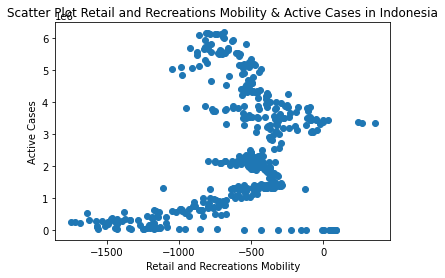

In [55]:
# made a scatter plot of retail and recreation mobility and active cases in indonesia
plt.scatter(retails_and_recreations["retail_and_recreation_percent_change_from_baseline"],
            active["active_cases"])
plt.xlabel('Retail and Recreations Mobility')
plt.ylabel('Active Cases')
plt.title('Scatter Plot Retail and Recreations Mobility & Active Cases in Indonesia')
plt.show()

## Grocery and Pharmacy & Active Cases

In [56]:
# top 5 of grocery and pharmacy mobility dataset
grocery_and_pharmacy.head()

,date,grocery_and_pharmacy_percent_change_from_baseline
0,2020-03-02,196.0
1,2020-03-03,210.0
2,2020-03-04,111.0
3,2020-03-05,151.0
4,2020-03-06,126.0


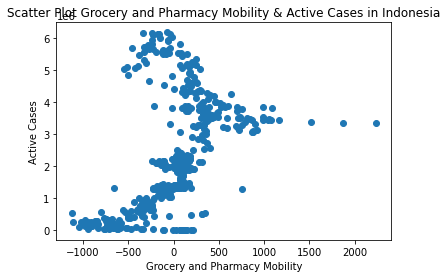

In [57]:
# made a scatter plot of grocery and pharmacy mobility and active cases in indonesia
plt.scatter(grocery_and_pharmacy["grocery_and_pharmacy_percent_change_from_baseline"],
            active["active_cases"])
plt.xlabel('Grocery and Pharmacy Mobility')
plt.ylabel('Active Cases')
plt.title('Scatter Plot Grocery and Pharmacy Mobility & Active Cases in Indonesia')
plt.show()

## Parks & Active Cases

In [58]:
# top 5 of parks mobility dataset
parks.head()

,date,parks_percent_change_from_baseline
0,2020-03-02,-44.0
1,2020-03-03,-66.0
2,2020-03-04,-115.0
3,2020-03-05,-59.0
4,2020-03-06,-44.0


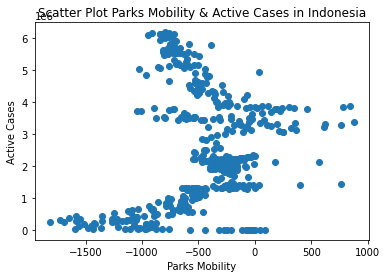

In [59]:
# made a scatter plot of parks mobility and active cases in indonesia
plt.scatter(parks["parks_percent_change_from_baseline"],
            active["active_cases"])
plt.xlabel('Parks Mobility')
plt.ylabel('Active Cases')
plt.title('Scatter Plot Parks Mobility & Active Cases in Indonesia')
plt.show()

## Transit Stations & Active Cases

In [60]:
# top 5 of transit stations mobility dataset
transit_stations.head()

,date,transit_stations_percent_change_from_baseline
0,2020-03-02,-8.0
1,2020-03-03,-19.0
2,2020-03-04,-62.0
3,2020-03-05,-27.0
4,2020-03-06,10.0


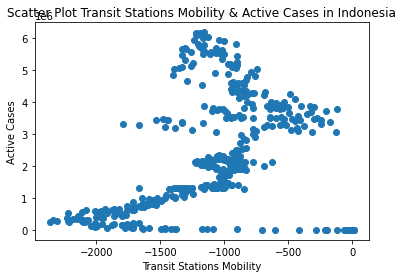

In [61]:
# made a scatter plot of transit stations mobility and active cases in indonesia
plt.scatter(transit_stations["transit_stations_percent_change_from_baseline"],
            active["active_cases"])
plt.xlabel('Transit Stations Mobility')
plt.ylabel('Active Cases')
plt.title('Scatter Plot Transit Stations Mobility & Active Cases in Indonesia')
plt.show()

## Workplaces & Active Cases

In [62]:
# top 5 of workplaces mobility dataset
workplaces.head()

,date,workplaces_percent_change_from_baseline
0,2020-03-02,159.0
1,2020-03-03,176.0
2,2020-03-04,159.0
3,2020-03-05,167.0
4,2020-03-06,187.0


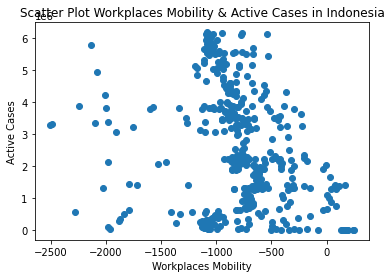

In [63]:
# made a scatter plot of workplaces mobility and active cases in indonesia
plt.scatter(workplaces["workplaces_percent_change_from_baseline"],
            active["active_cases"])
plt.xlabel('Workplaces Mobility')
plt.ylabel('Active Cases')
plt.title('Scatter Plot Workplaces Mobility & Active Cases in Indonesia')
plt.show()

## Residential & Active Cases

In [64]:
# top 5 of residential mobility dataset
residential.head()

,date,residential_percent_change_from_baseline
0,2020-03-02,12.0
1,2020-03-03,11.0
2,2020-03-04,42.0
3,2020-03-05,23.0
4,2020-03-06,35.0


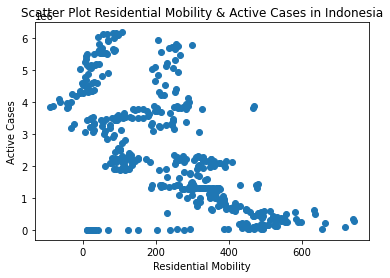

In [65]:
# made a scatter plot of residential mobility and active cases in indonesia
plt.scatter(residential["residential_percent_change_from_baseline"],
            active["active_cases"])
plt.xlabel('Residential Mobility')
plt.ylabel('Active Cases')
plt.title('Scatter Plot Residential Mobility & Active Cases in Indonesia')
plt.show()

# Linear Regression Modelling

In [66]:
# define linear regression model
lr_model = LinearRegression()

## Retail and Recreation Mobility & Active Cases

In [67]:
# define predictor and response variables
X, y = dataset[["retail_and_recreation_percent_change_from_baseline"]], dataset.active_cases

# fit regression model
lr_model.fit(X, y)

# calculate R-Squared of Regression Model
r_squared = lr_model.score(X, y)

# view R-Squared values
print(r_squared)

0.08449308382799592


## Grocery and Pharmacy Mobility & Active Cases

In [68]:
# define predictor and response variables
X, y = dataset[["grocery_and_pharmacy_percent_change_from_baseline"]], dataset.active_cases

# fit regression model
lr_model.fit(X, y)

# calculate R-Squared of Regression Model
r_squared = lr_model.score(X, y)

# view R-Squared values
print(r_squared)

0.18617348353503516


## Parks Mobility & Active Cases

In [69]:
# define predictor and response variables
X, y = dataset[["parks_percent_change_from_baseline"]], dataset.active_cases

# fit regression model
lr_model.fit(X, y)

# calculate R-Squared of Regression Model
r_squared = lr_model.score(X, y)

# view R-Squared values
print(r_squared)

0.041524849625223736


## Transit Stations Mobility & Active Cases

In [70]:
# define predictor and response variables
X, y = dataset[["transit_stations_percent_change_from_baseline"]], dataset.active_cases

# fit regression model
lr_model.fit(X, y)

# calculate R-Squared of Regression Model
r_squared = lr_model.score(X, y)

# view R-Squared values
print(r_squared)

0.14473619759398304


## Workplaces Mobility & Active Cases

In [71]:
# define predictor and response variables
X, y = dataset[["workplaces_percent_change_from_baseline"]], dataset.active_cases

# fit regression model
lr_model.fit(X, y)

# calculate R-Squared of Regression Model
r_squared = lr_model.score(X, y)

# view R-Squared values
print(r_squared)

0.06420213620085258


## Residential Mobility & Active Cases

In [72]:
# define predictor and response variables
X, y = dataset[["residential_percent_change_from_baseline"]], dataset.active_cases

# fit regression model
lr_model.fit(X, y)

# calculate R-Squared of Regression Model
r_squared = lr_model.score(X, y)

# view R-Squared values
print(r_squared)

0.4143120049620561


# FBProphet Modelling

In [73]:
# import fbprophet library
from fbprophet import Prophet

In [74]:
# define fbprophet model
model = Prophet(interval_width=0.95,weekly_seasonality=True,)

# set X and y or 'ds' and 'y' for forecasting
prophet_confirmed=pd.DataFrame(zip(list(dataset.index),list(dataset["Confirmed"])),columns=['ds','y'])

In [75]:
# fit dataset
model.fit(prophet_confirmed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [76]:
# made a forecast for 17 days ahead
forecast_c=model.make_future_dataframe(periods=17)
forecast_confirmed=forecast_c.copy()

In [77]:
# predict forecast for 17 days ahead
confirmed_forecast=model.predict(forecast_c)
print(confirmed_forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])

            ds          yhat    yhat_lower    yhat_upper
0   2020-03-02 -2.631812e+04 -2.190039e+05  1.627908e+05
1   2020-03-03 -2.964488e+04 -2.195288e+05  1.793944e+05
2   2020-03-04 -2.267080e+04 -2.162571e+05  1.773362e+05
3   2020-03-05 -1.021787e+04 -2.055333e+05  1.897604e+05
4   2020-03-06  6.302547e+02 -1.969623e+05  1.968032e+05
..         ...           ...           ...           ...
466 2021-06-11  6.588632e+07  6.532293e+07  6.644683e+07
467 2021-06-12  6.606936e+07  6.542956e+07  6.673253e+07
468 2021-06-13  6.624603e+07  6.553952e+07  6.695374e+07
469 2021-06-14  6.641461e+07  6.562572e+07  6.722696e+07
470 2021-06-15  6.659115e+07  6.572625e+07  6.750840e+07

[471 rows x 4 columns]


Figure(720x432)


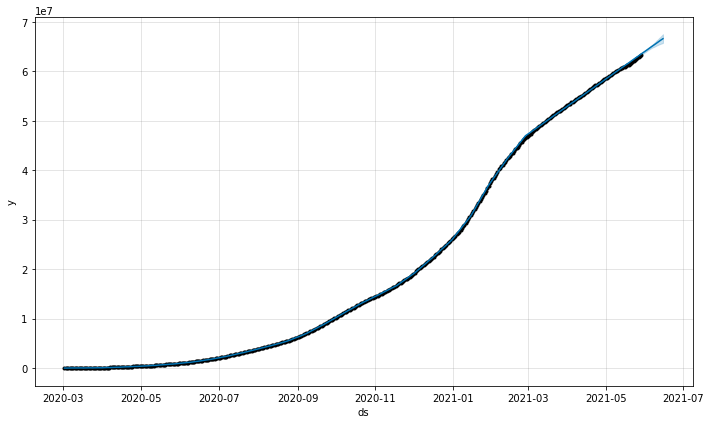

In [78]:
# plot forecast 
print(model.plot(confirmed_forecast))

Figure(648x432)


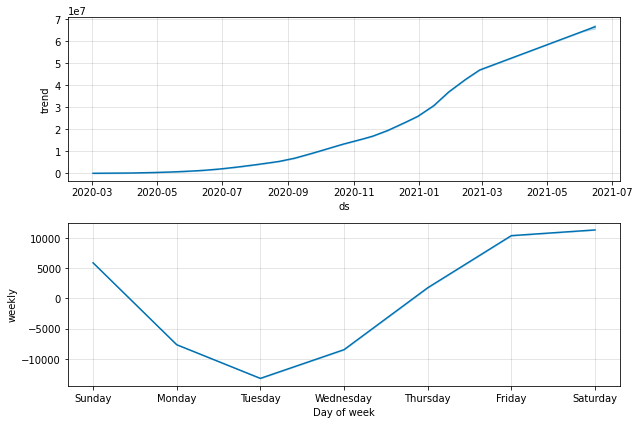

In [79]:
# plot component of forecast
print(model.plot_components(confirmed_forecast))

In [80]:
# dataframe that extends into future 12 months
future_dates = model.make_future_dataframe(periods = 3, freq='M')
print('First week to forecast.')
future_dates.tail()

First week to forecast.


,ds
452,2021-05-28
453,2021-05-29
454,2021-05-31
455,2021-06-30
456,2021-07-31


In [81]:
# predictions
forecast = model.predict(future_dates)

# predictions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
450,2021-05-26,6.295388e+07,6.275265e+07,6.315295e+07
451,2021-05-27,6.314620e+07,6.294363e+07,6.335442e+07
452,2021-05-28,6.333691e+07,6.315200e+07,6.353143e+07
453,2021-05-29,6.351995e+07,6.330796e+07,6.370121e+07
454,2021-05-31,6.386520e+07,6.366798e+07,6.406847e+07
455,2021-06-30,6.932739e+07,6.725548e+07,7.140037e+07
456,2021-07-31,7.499229e+07,6.909488e+07,8.085814e+07


In [82]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})
fc.head()

,ds,yhat
0,2020-03-02,-26318.121315
1,2020-03-03,-29644.881377
2,2020-03-04,-22670.802950
3,2020-03-05,-10217.874581
4,2020-03-06,630.254750


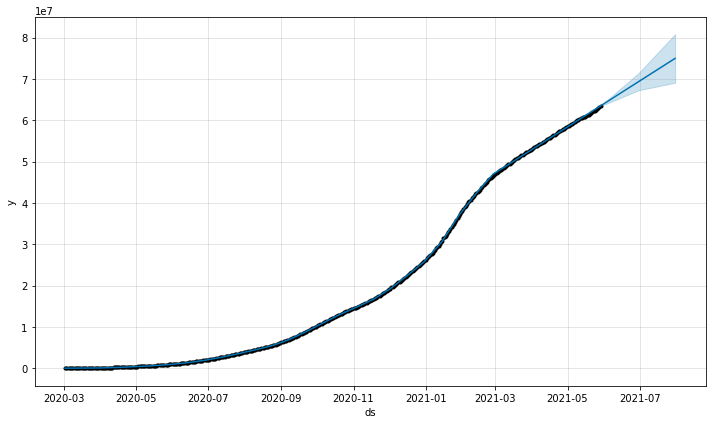

In [83]:
# visualizing predictions
sales_forecast = model.plot(forecast);

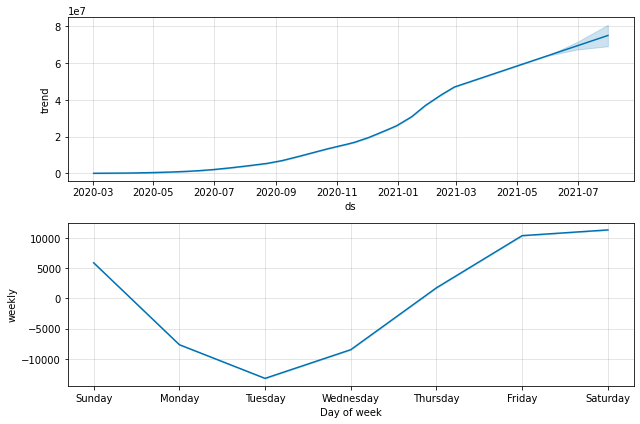

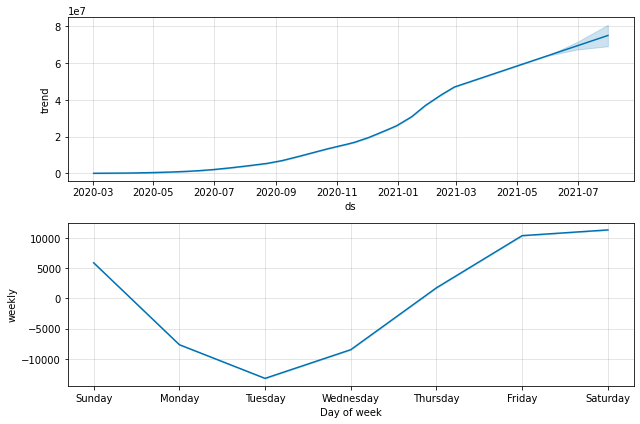

In [84]:
model.plot_components(forecast)

# Conclusion

1. Retail and Recreational: mobility towards places such as restaurants, cafes, shopping
centers, museums, libraries, and picture theatres;
2. Grocery and Pharmacy:  mobility trends for places such as grocery shops, food warehouses, markets, local hats, farmer’s markets, specialty food shops, different drug or
medicine stores, and pharmacies;
3. Parks: places of attraction including local parks, national parks, public beaches,
marinas, dog parks, plazas, and public gardens;
4. Transit stations: a process by which a person moves from one place to places like
public transport hubs such as subway, bus, and train stations;
5. Workplaces: the process of going to places of work from a home;
6. Residential mobility: mobility in the direction of places of residence where a person lived.

**Effect of Mobility by Categories on COVID-19 Dynamics in Indonesia:**


---

Based on R2 of each category of mobility in Indonesia and its active cases:
1. Retail and Recreations: 0.085 
2. Grocery and Pharmacy: 0.186
3. Parks: 0.042
4. Transit Stations: 0.145
5. Workplaces: 0.064
6. Residential: 0.414



Mobility on **Residential** have the highest correlation with number of COVID-19 cases. Subsequently, 
* Grocery and Pharmacy
* Transit Stations
* Retail and Recreations
* Workplaces
* Parks


Groceries and Pharmacy correlated on the increasing of COVID-19 new cases, because during pandemic, traditional markets, modern markets, and drugstore are essentials for strive during pandemic, so there's no restrictions, and all business in this category are still allowed to be open. Other than that, mostly traditional market tend to be crowded and unorganized.

Transit Stations correlated on the increasing number of COVID-19 cases since the increasing number of passenger during public holidays, religious day/event, make the visits to transit stations within the city increased. Also, confined spaces and closed environments on public transportations have a high risk of infectious disease transmission, since it potentially leads to crowding.

Workplaces doesn't have a significant correlation since some of workers required to work from office, but eventhough required to work from office, the compliance on health protocol, such as mask wearing, temperature check, and washing hands.

Parks has the lowest correlation with COVID-19 since it's an open space, and tend not to be as crowded as other category. And the air circulation is much better in open space, therefore the probability of infectious disease to transferred to others is low.

**Based on future forecasting using FBProphet:**
The number of confirmed cases in Indonesia will show an increasing number for 17 days ahead, and also for 3 months ahead.

Decision makers in public health could utilize the current analysis to anticipate increased COVID-19 cases, especially during seasonal events, such as annual religious holidays or other long holidays.

From this analysis, we have some recommendations for policy maker:
1. Control new cases and new clusters and prevent community transmission by rapidly **finding and isolating all cases**, **providing the infected one with appropriate care**, and **tracing**, **quarantining**, and supporting all contacts.
2. Suppress community transmission through **infection prevention** and **control measures**, population level **physical distancing measures**, and appropriate and proportionate **restrictions** or **non-essential domestic and international travels**.
3. Reduce **mortality rate** by **providing appropriate clinical care** for those affected by COVID-19, ensuring the **continuity of essential health and social services**, and **protecting frontline workers and vulnerable populations**.